# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(1938, 120)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Barcount', '10Y_Average', '10Y_Spread', '2Y_Open', '2Y_High',
       ...
       'ZS_Average', 'ZS_Spread', 'ZW_Open', 'ZW_High', 'ZW_Low', 'ZW_Close',
       'ZW_Volume', 'ZW_Barcount', 'ZW_Average', 'ZW_Spread'],
      dtype='object', length=120)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2Y_Open,2Y_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


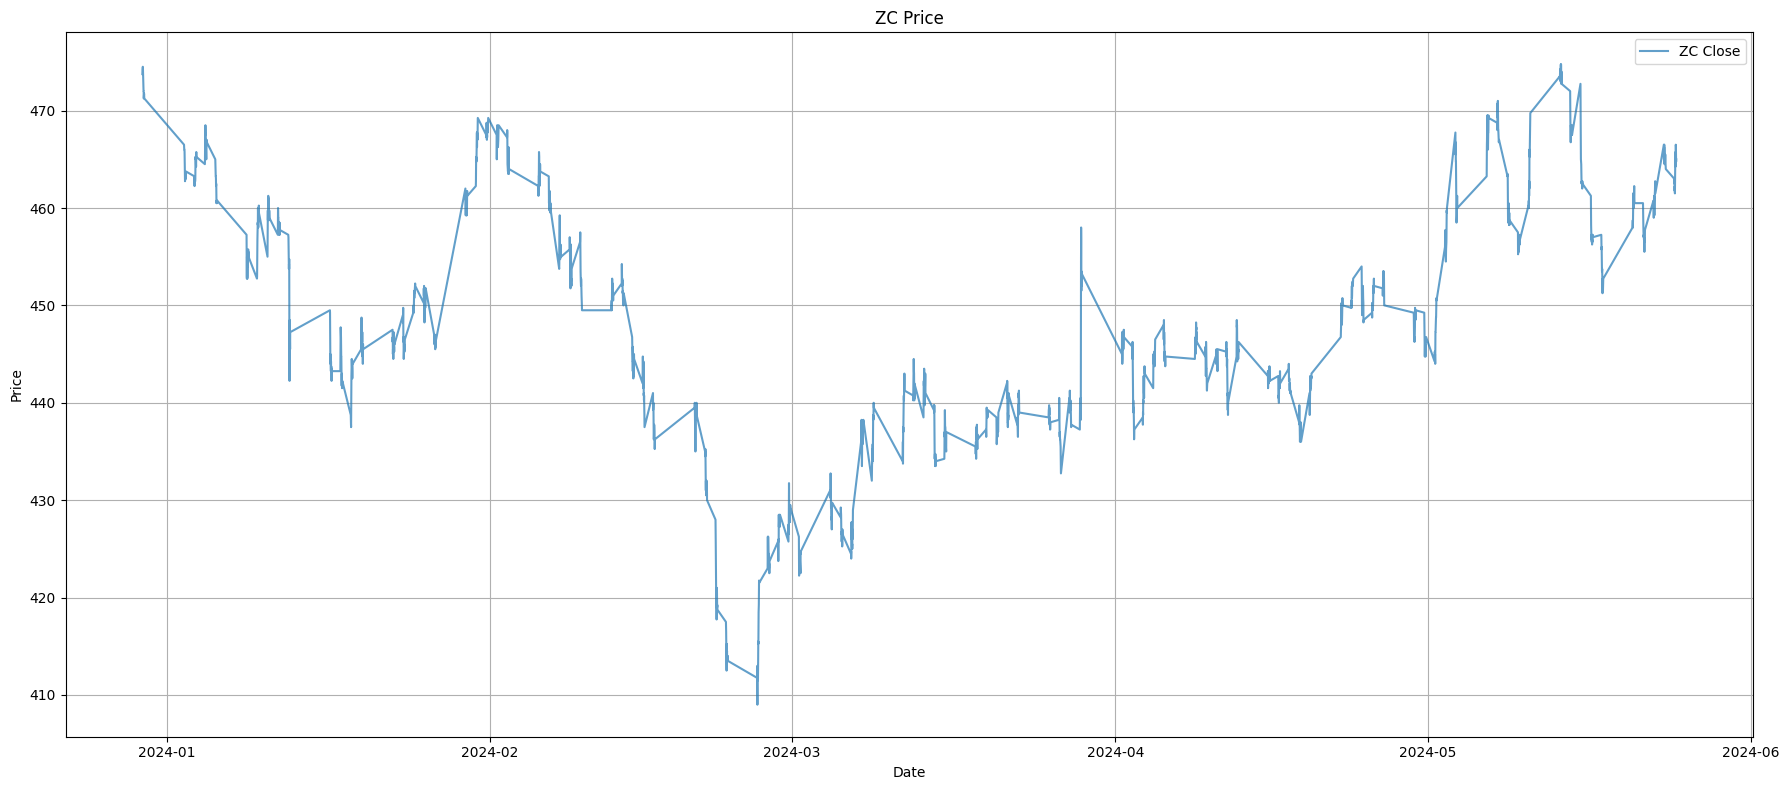

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]
target_fut_df

,ZC_Close
Date,
2023-12-29 15:30:00+00:00,473.75
2023-12-29 15:45:00+00:00,474.25
2023-12-29 16:00:00+00:00,474.25
2023-12-29 16:15:00+00:00,474.50
2023-12-29 16:30:00+00:00,474.50
...,...
2024-05-24 19:00:00+00:00,466.50
2024-05-24 19:15:00+00:00,466.25
2024-05-24 19:30:00+00:00,465.50


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 135
Hurst: 0.5093444138309431


# Time Series Momentum

$$
\text{TSMOM}_i = \frac{P_i(t) - P_i(t - T)}{P_i(t - T)}
$$

where:

- \( P_i(t) \) is the current price of asset \( i \) at time \( t \).
- \( P_i(t - T) \) is the price of asset \( i \) at time \( t - T \).
- \( T \) is the look-back period.

https://www.sciencedirect.com/science/article/pii/S0304405X11002613

https://www.sciencedirect.com/science/article/pii/S1042443118303093

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2407199 

In [8]:
from signals import signal_tsmom

tsmom_signals = signal_tsmom(target_fut_df[f"{TARGET_FUT}_Close"], lookback=abs(HALF_LIFE), contra_lookback=abs(HALF_LIFE)//2)
tsmom_signals

,TSMOM,CONTRA
Date,,
2023-12-29 15:30:00+00:00,0,0
2023-12-29 15:45:00+00:00,0,0
2023-12-29 16:00:00+00:00,0,0
2023-12-29 16:15:00+00:00,0,0
2023-12-29 16:30:00+00:00,0,0
...,...,...
2024-05-24 19:00:00+00:00,1,0
2024-05-24 19:15:00+00:00,1,0
2024-05-24 19:30:00+00:00,1,0


## Datamining

In [14]:
from tqdm import tqdm
from quant_equations import get_ou
from signals import param_search_tsmom

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

stats_df = param_search_tsmom(futs_df, f'{TARGET_FUT}_Close', period=INTERVAL, hurst=HURST, initial_window=abs(HALF_LIFE))
cumret_df= stats_df[stats_df["Metric"] == "Cumulative Returns"]
BEST_WINDOW = cumret_df["Window"].values[0]
BEST_CONTRA = cumret_df["Contrarian Window"].values[0]
BEST_STD_THRESHOLD = cumret_df["STD Threshold"].values[0]

stats_df.drop(columns=["Rets"])

param_search_tsmom:   0%|          | 0/42 [00:00<?, ?it/s]

param_search_tsmom: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


,Window,Contrarian Window,STD Threshold,Cumulative_Returns,Max Ret,Max Loss,Variance,STD,Max_Drawdown,Drawdown_Length,Sharpe,Trades_Count,Trades_per_Interval,Trading_Intervals,Rets_Skew,Rets_Kurt,Metric
0,90,3,1.485983,0.140324,0.034714,-0.018202,0.000007,0.002711,-0.122472,804,1.581743e-02,126,0.065015,1938,1.723270,25.812570,Sharpe
1,90,3,1.485983,0.140324,0.034714,-0.018202,0.000007,0.002711,-0.122472,804,1.581743e-02,126,0.065015,1938,1.723270,25.812570,Cumulative Returns
2,11,3,1.485983,0.073216,0.034714,-0.027952,0.000008,0.002765,-0.091322,947,1.723125e-32,332,0.171311,1938,0.611206,23.889608,Max Drawdown


## Visual Results

Cumulative returns from the strategy: 14.03%


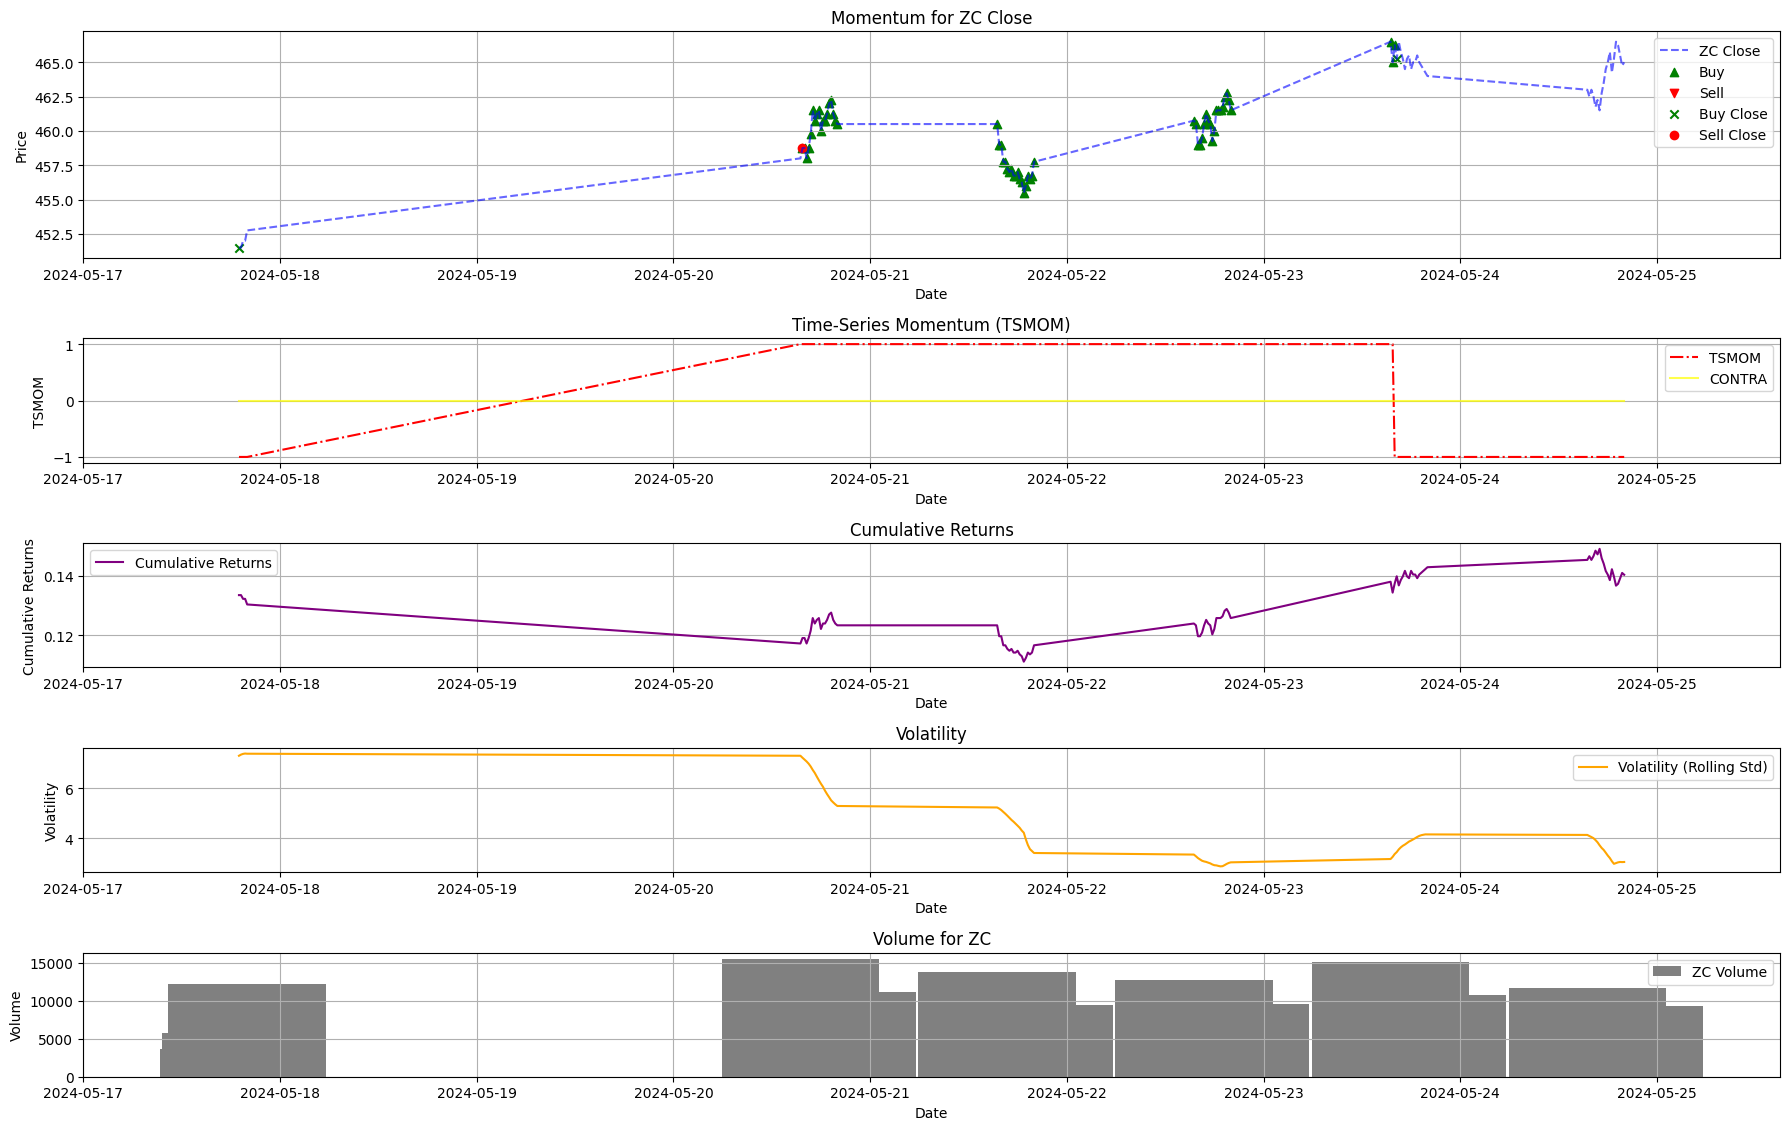

In [15]:
import matplotlib.pyplot as plt
from signals import tsmom_backtest


backtest_df = futs_df[[f'{TARGET_FUT}_Close', f'{TARGET_FUT}_Volume']].copy()
backtest_df, stats_df = tsmom_backtest(backtest_df, f'{TARGET_FUT}_Close', period=INTERVAL, lookback=BEST_WINDOW, contra_lookback=BEST_CONTRA, std_threshold=BEST_STD_THRESHOLD)
backtest_df['cRets'] = (1 + backtest_df['Ret']).cumprod() - 1
backtest_df['Volatility'] = backtest_df[f'{TARGET_FUT}_Close'].rolling(window=BEST_WINDOW).std().fillna(0.)
print(f"Cumulative returns from the strategy: {backtest_df['cRets'].iloc[-1]*100.:.02f}%")

# Zoom in
# backtest_df = backtest_df.tail(100)

plt.figure(figsize=(18, 12))
buy_signals = backtest_df[backtest_df['SB'] > 0]
sell_signals = backtest_df[backtest_df['SS'] < 0]
long_closed = backtest_df[backtest_df['Closed'] > 0]
short_closed = backtest_df[backtest_df['Closed'] < 0]

ax1 = plt.subplot2grid((12, 1), (0, 0), rowspan=3, colspan=1)
ax1.plot(backtest_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', color='blue', alpha=0.6, linestyle='--')
ax1.scatter(buy_signals.index, buy_signals[f'{TARGET_FUT}_Close'], color='green', marker='^', label='Buy')
ax1.scatter(sell_signals.index, sell_signals[f'{TARGET_FUT}_Close'], color='red', marker='v', label='Sell')
ax1.scatter(long_closed.index, long_closed[f'{TARGET_FUT}_Close'], color='green', marker='x', label='Buy Close')
ax1.scatter(short_closed.index, short_closed[f'{TARGET_FUT}_Close'], color='red', marker='o', label='Sell Close')

ax1.set_title(f'Momentum for {TARGET_FUT} Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot2grid((12, 1), (3, 0), rowspan=2, colspan=1, sharex=ax1)
ax2.plot(backtest_df['TSMOM'], label='TSMOM', color='red', linestyle='-.')
ax2.plot(backtest_df['CONTRA'], label='CONTRA', color='yellow', linestyle='-', alpha=0.7)
ax2.set_title('Time-Series Momentum (TSMOM)')
ax2.set_xlabel('Date')
ax2.set_ylabel('TSMOM')
ax2.legend()
ax2.grid(True)

ax3 = plt.subplot2grid((12, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
ax3.plot(backtest_df['cRets'], label='Cumulative Returns', color='purple')
ax3.set_title('Cumulative Returns')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Returns')
ax3.legend()
ax3.grid(True)

ax4 = plt.subplot2grid((12, 1), (7, 0), rowspan=2, colspan=1, sharex=ax1)
ax4.plot(backtest_df['Volatility'], label='Volatility (Rolling Std)', color='orange')
ax4.set_title('Volatility')
ax4.set_xlabel('Date')
ax4.set_ylabel('Volatility')
ax4.legend()
ax4.grid(True)

ax5 = plt.subplot2grid((12, 1), (9, 0), rowspan=2, colspan=1, sharex=ax1)
ax5.bar(backtest_df.index, backtest_df[f'{TARGET_FUT}_Volume'], label=f'{TARGET_FUT} Volume', color='grey')
ax5.set_title(f'Volume for {TARGET_FUT}')
ax5.set_xlabel('Date')
ax5.set_ylabel('Volume')
ax5.legend()
ax5.grid(True)

plt.tight_layout()
plt.show()